In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors

import config
config.config(channel='shap',lemo='none', n_steps=8,cfg_bits=[0,1,0,1,1,1,1], active_probes=False)

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB1::9::INSTR', 'GPIB1::23::INSTR')
Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


    Low terminal: FLO
    Auto output off: 1
    Protection: 1
    Resistance mode: FIX
    Shunt resistance : +2.00000000E+009
    Output current mode: FIX
    Output current level: -1.00000000E-006
    Output voltage range: +2.00000000E+000
    Output status: 1
        
HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


    Number of pattern positions: +1000
    Source of the trigger: IMM
    Period of the pulse: +1.5000E-08
    Duty cycle of the pulse: +5.0000E+01
    Rise time of the pulse: +3.0000E-09
    Type of pulse: PATTERN
    CH1 data: 20 1's, 980 0's
    CH2 data: as the clock
    STRB data: 20 1's, 980 0's
    Type of the pulse: NRZ
    Internal impedance (source): +5.0000E+01
    External impedance (termination): +1.0000E+02
    High level: +1.2000E+00
    Low level: +0.0000E+00
    Output 1 status: 1
    Output 2 status: 1
        
LECROY,

In [108]:
#print(config.lecroy.query('C1:CRVA? HREL').split(',')[2])
config.ps.write(':SOUR:CURR:LEV -.0e-6')

23

In [106]:
config.ps.write(':OUTP:STAT ON')
config.pg.write(':OUTP2 OFF')

12

In [8]:
# set proper time division for this analysis
#config.lecroy.write('TDIV 200NS')
# suppress channel for noise stuff
#config.lecroy.write('F3:TRA OFF')
# reset inj
config.ps.write(':SOUR:CURR:LEV -0.07e-6')
time.sleep(2)
channel_name = config.channel_name
lemo_name = config.lemo_name
gain = config.lemo_gain
attenuation = config.attenuation
if config.active_prbs:
	gain_lane = 1/attenuation # times 1.9
else:
	gain_lane = gain # divide by lemo gain

df = config.pd.DataFrame()
for i, cl in enumerate(config.current_lev):
	# set current level
	config.ps.write(f':SOUR:CURR:LEV {cl}')
	time.sleep(10)
	# N sample to average and extract std from
	data = pd.DataFrame.from_dict(config.lecroy.get_channel(channel_name='C',n_channel=config.channel_num)['waveforms'][0])
	data['Amplitude (V)'] = (data['Amplitude (V)'] - data['Amplitude (V)'][0])/gain_lane
	data.insert(0, 'Current level step', i)
	data.insert(1, 'Current level (A)', cl)
	df = pd.concat((df, data))

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
if config.active_prbs:
	str_type = 'active_prbs'
else:
	str_type = ''
df.to_csv(f'G:/My Drive/PHD/FALCON/measures/transient/{channel_name}/{channel_name}_{config.config_bits_str}_nominal_{lemo_name}_{datetime_str}.tsv', sep='\t')

In [34]:
#============ THIS TO GET DATA FROM OLDER MEASUREMENTS ====================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors
import config

#path = 'G:/My Drive/PHD/FALCON/measures/transient/csa/csa_0101011_nominal_160424_101536.tsv'
path = 'G:/My Drive/PHD/FALCON/measures/transient/shap/shap_0101011_nominal_160424_105215.tsv'
df = pd.read_csv(path,sep='\t')
datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
arr_split = path.split('/')
channel_name = arr_split[6]
config_bits_str = arr_split[-1].split('_')[1]
config_bits = [int(x) for x in config_bits_str]
config.config(channel=channel_name,n_steps=8,cfg_bits=config_bits,cfg_inst=False,lemo=False)

current range: -7e-08, -1.5e-06
Injection integral (min and max): 1.0000000000000084e-16, -1.715e-13
photon energy @ 9 keV: -0.2531557775003489, 434.16215841309474
Peaking time: 430 ns
Config bits: 0101011
Channel to be tested: shap


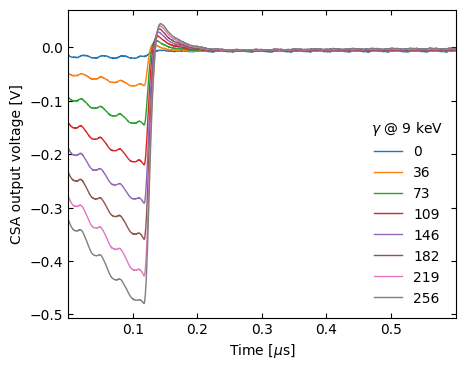

In [25]:
t_s = 300e-9 if config.channel_name == 'csa' else -100e-9
t_e = 900e-9 if config.channel_name == 'csa' else 1.8e-6
sub_df = df[df['Time (s)'].between(t_s, t_e)]

colours = list(mcolors.TABLEAU_COLORS.keys())
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)
for i, cl in enumerate(config.current_lev):
	ax.plot(
		sub_df[sub_df['Current level step'] == i]['Time (s)']*10**6 - t_s*10**6,
		sub_df[sub_df['Current level step'] == i]['Amplitude (V)'],
		'-', linewidth=1, color=colours[i])
ax.set_xlabel('Time [$\\mu$s]')
ax.set_ylabel(f'{channel_name.upper() if channel_name == 'csa' else 'Shaper'} output voltage [V]')
ax.tick_params(right=True, top=True, direction='in')
ax.autoscale(enable=True, axis='x', tight=True)

ax.legend(np.linspace(0,256,8).astype(int),
		  title=f"$\\gamma$ @ {config.photon_energy} keV",
		  frameon=False)
if channel_name == 'shap':
	ax.text(.01,.01,f'$t_p$ = {config.peaking_time} ns',ha='left',va='bottom',transform=ax.transAxes)

# if config.active_prbs:
# 	str_type = 'active_prbs'
# else:
# 	if gain < 3:
# 		'LEMOLOW'
# 	else:
# 		'LEMOHIGH'
plt.savefig(f'G:/My Drive/PHD/FALCON/measures/transient/{channel_name}/{channel_name}_{config.config_bits_str}_nominal_{datetime_str}.pdf',dpi=300)

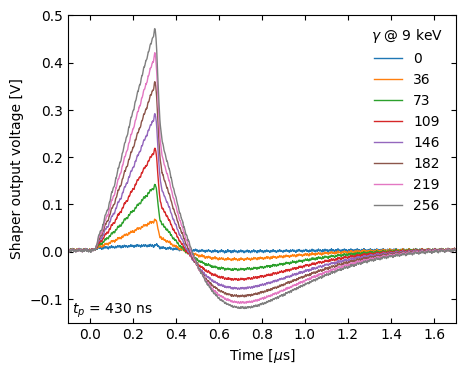

In [39]:
# for 0 ns representation
t_s = 000e-9 if config.channel_name == 'csa' else 000e-9
t_e = 900e-9 if config.channel_name == 'csa' else 1.9e-6
sub_df = df[df['Time (s)'].between(t_s, t_e)]

t_csa_reset_s = 120e-3 # us
colours = list(mcolors.TABLEAU_COLORS.keys())
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)
for i, cl in enumerate(config.current_lev):
	ax.plot(
		sub_df[sub_df['Current level step'] == i]['Time (s)']*10**6 - t_s*10**6 - t_csa_reset_s,
		sub_df[sub_df['Current level step'] == i]['Amplitude (V)'],
		'-', linewidth=1, color=colours[i])
ax.set_xlabel('Time [$\\mu$s]')
ax.set_ylabel(f'{channel_name.upper() if channel_name == 'csa' else 'Shaper'} output voltage [V]')
ax.tick_params(right=True, top=True, direction='in')
#ax.set_xlim((-0.1, 0.6))
ax.set_xlim((-0.1, 1.7))

ax.legend(np.linspace(0,256,8).astype(int),
		  title=f"$\\gamma$ @ {config.photon_energy} keV",
		  frameon=False)
if channel_name == 'shap':
	ax.text(.01,.01,f'$t_p$ = {config.peaking_time} ns',ha='left',va='bottom',transform=ax.transAxes)

# if config.active_prbs:
# 	str_type = 'active_prbs'
# else:
# 	if gain < 3:
# 		'LEMOLOW'
# 	else:
# 		'LEMOHIGH'
plt.savefig(f'G:/My Drive/PHD/FALCON/measures/transient/{channel_name}/{channel_name}_{config.config_bits_str}_nominal_{datetime_str}.pdf',dpi=300)